**Day 5 - June 9 2022**

| Student                       | ID        |
| -------------                 |:---------:|
| Benjamin Starostka Jakobsen   | s184198   |
| Muhammad REDACTED             | REDACTED  |
| Victor REDACTED               | REDACTED  |

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import chisquare

sns.set_style("white")

# Exercise 6
# Markov Chain Monte Carlo

## 1.
**The number of busy lines in a trunk group (Erlang system) is given by a truncated Poisson distribution**

$$
P(i) = c \cdot \frac{A^i}{i!} \;, \;\; i = 0,\dots,m
$$

**Generate values from this distribution by applying the Metropolis-Hastings algorithm, verify with a $\chi^2$-test. You can use the parameter values from exercise 4.**

In [ ]:
def truncated_Poisson_distr(A, m):
    distr = {}
    var = np.arange(0, m + 1)
    for i in var:
        distr[i] = A**i / np.math.factorial(i)

    tot = np.sum(list(distr.values()))
    distr = {k: v / tot for k, v in distr.items()}  # Normalization
    return distr

In [ ]:
A = 8
m = 10

distr = truncated_Poisson_distr(A, m)

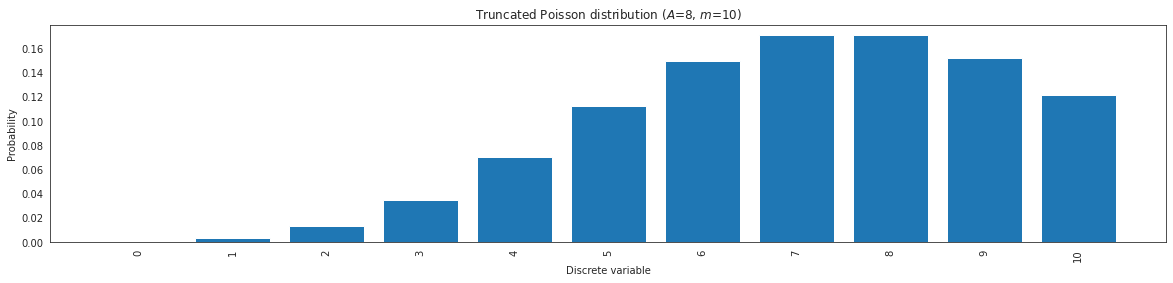

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.bar(x=[str(t) for t in distr.keys()], height=list(distr.values()), color="C0")
ax.set(
    xlabel="Discrete variable",
    ylabel="Probability",
    title=rf"Truncated Poisson distribution ($A$={A}, $m$={m})",
)
plt.xticks(rotation=90)
plt.show()

The proposal distribution $q$ is 
$$
q(j|i) = \left\{
    \begin{array}{ll}
        0.5\;\; \text{if}\:\:\:|j-i| =1\:\:\:\: \text{or}\:\:\:\:\: |j-i|=m \\
        0 \;\;\;\;\text{otherwise}
    \end{array}
\right.
$$
It is symmetric, $q(j|i) = q(i|j)$.

Basically, when sampling from $q$, the candidate state $j$ can only be $i-1$ or $i+1$ (and it loops between 0 and $m$). 

In [ ]:
def sample_q(i, m):
    if np.random.uniform() < 0.5:
        j = i - 1
        if i == 0:
            j = m
    else:
        j = i + 1
        if i == m:
            j = 0
    return j

The acceptance probability $\alpha$ is thus,
$$
\alpha = \min(1, \frac{P(j)q(j|i)}{P(i)q(i|j)}) = \min(1, \frac{P(j)}{P(i)}) = \min(1, \frac{A^{j-i}\:i!}{j!})
$$


In [ ]:
def MH_algorithm_1(A, m, s_0, N_iter):
    counter_accept = 0
    traces = []

    i = s_0
    for n in range(N_iter):

        j = sample_q(i, m)

        ratio = A ** (j - i) * np.math.factorial(i) / np.math.factorial(j)
        alpha = min(1, ratio)

        if np.random.uniform() < alpha:  # Accept
            i = j
            counter_accept += 1

        # Else, reject and i stays i.
        traces.append(i)

    print(f"Proposal accepted {100 * counter_accept / N_iter:2.3f}% of the times")
    return np.array(traces)

In [ ]:
def chi2_test(distr_exp, distr_obs, N, plot=True):

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(20, 4))
        ax.bar(
            x=[str(t) for t in distr_exp.keys()],
            height=list(distr_exp.values()),
            color="C0",
            alpha=0.3,
            label="Expected distribution",
        )
        ax.bar(
            x=[str(t) for t in distr_obs.keys()],
            height=list(distr_obs.values()),
            color="C1",
            alpha=0.4,
            label="Observed distribution",
        )
        ax.set(xlabel="Discrete variable", ylabel="Probability")
        ax.legend()
        plt.xticks(rotation=90)
        plt.show()

    f_obs = np.array(list(distr_obs.values())) * N
    f_exp = np.array(list(distr_exp.values())) * N

    chisq, p = chisquare(f_obs, f_exp=f_exp)
    if p < 10 ** (-5):
        print("Rejection of the hypothesis, p-value:", p)
    else:
        print("No rejection of the hypothesis, p-value:", p)

In [ ]:
N_iter = 50000
s_0 = 2
trace = MH_algorithm_1(A, m, s_0, N_iter)

Proposal accepted 83.012% of the times


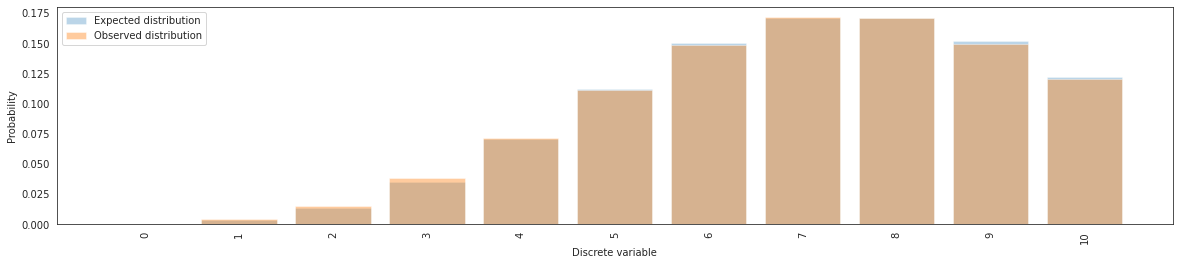

Rejection of the hypothesis, p-value: 8.997756013930969e-07


In [ ]:
values, counts = np.unique(trace, return_counts=True)
counts_dic = {k: 0 for k in np.arange(m + 1)}
for i, val in enumerate(values):
    counts_dic[val] = counts[i]

distr_MHalgo = {k: v / N_iter for k, v in counts_dic.items()}

chi2_test(distr, distr_MHalgo, N_iter)

Let's consider a **burn in** fraction of 25%, i.e. we discard the first quarter of samples generated. It is done in order to have samples not dependent of the starting state.

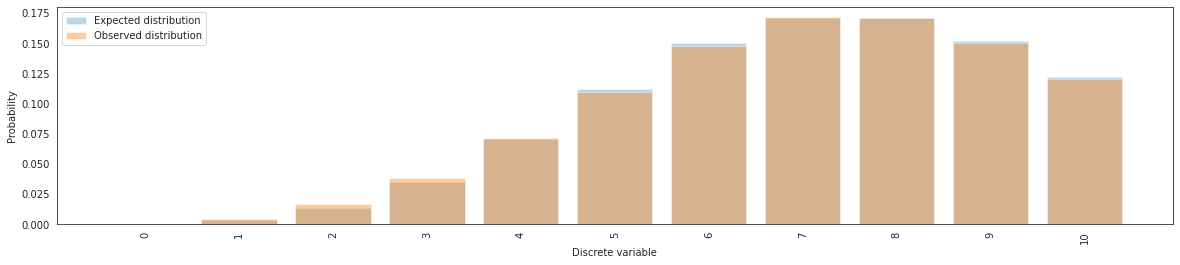

Rejection of the hypothesis, p-value: 4.8325939038378645e-11


In [ ]:
# Burnin-fraction
burnin_frac = 0.25
burnin_idx = int(N_iter * burnin_frac)

trace_burnin = trace[burnin_idx:]
values, counts = np.unique(trace_burnin, return_counts=True)
counts_dic = {k: 0 for k in np.arange(m + 1)}
for i, val in enumerate(values):
    counts_dic[val] = counts[i]

tot = np.sum(list(counts_dic.values()))
distr_MHalgo_burnin = {k: v / tot for k, v in counts_dic.items()}

chi2_test(distr, distr_MHalgo_burnin, tot)

Let's consider a way to uncorrelate the samples. 
* By taking a random subset of the samples. 
* By taking samples every $k=10$ iterations.

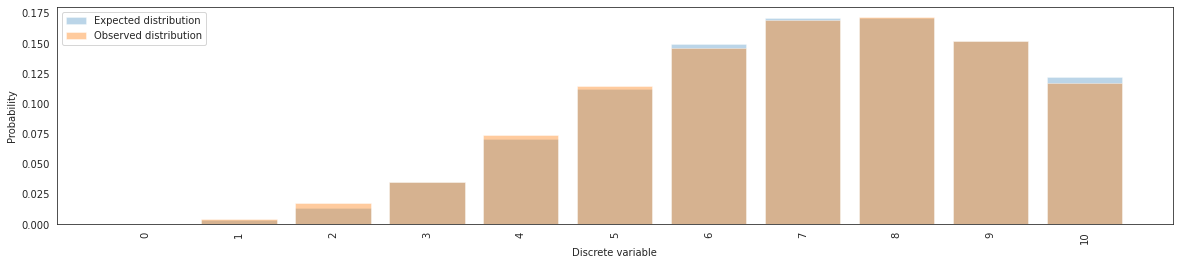

No rejection of the hypothesis, p-value: 0.3169183651517397


In [ ]:
# Random subset
subset_idx = np.random.choice(np.arange(N_iter), size=int(0.75 * N_iter))
# Subset every 10 iterations
subset_idx = np.arange(0, N_iter, 10)

trace_sub = trace[subset_idx]

values, counts = np.unique(trace_sub, return_counts=True)
counts_dic = {k: 0 for k in np.arange(m + 1)}
for i, val in enumerate(values):
    counts_dic[val] = counts[i]

tot = np.sum(list(counts_dic.values()))
distr_MHalgo_sub = {k: v / tot for k, v in counts_dic.items()}


chi2_test(distr, distr_MHalgo_sub, tot)

## 2.
**For two different call types the joint number of occupied lines is given by**
$$
P(i, j)=c \cdot \frac{A_{1}^{i}}{i !} \frac{A_{2}^{j}}{j !} \quad 0 \leq i+j \leq m
$$
**You can use $A1,A2 =4$ and $m=10$.**

In [ ]:
def two_calls_distr(A1, A2, m):
    distr = {}
    for i in np.arange(m + 1):
        for j in np.arange(m + 1 - i):
            distr[(i, j)] = (A1**i / np.math.factorial(i)) * (
                A2**j / np.math.factorial(j)
            )

    tot = np.sum(list(distr.values()))
    distr = {k: v / tot for k, v in distr.items()}  # Normalization
    return distr

In [ ]:
A1 = 4
A2 = 4
m = 10
distr_2 = two_calls_distr(A1, A2, m)

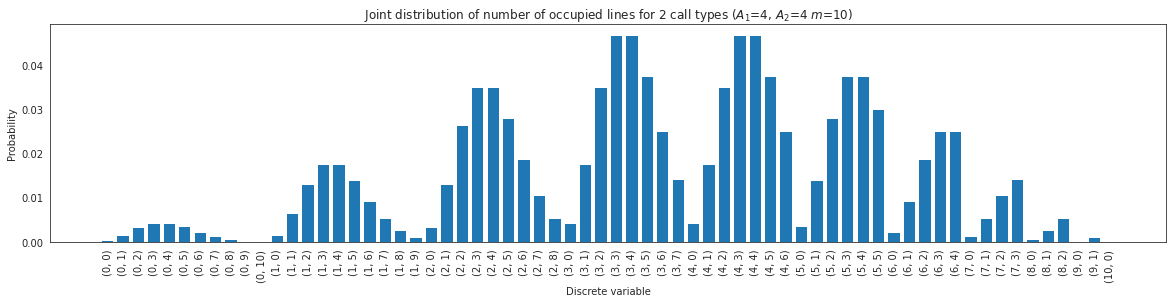

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.bar(x=[str(t) for t in distr_2.keys()], height=list(distr_2.values()), color="C0")
ax.set(
    xlabel="Discrete variable",
    ylabel="Probability",
    title=r"Joint distribution of number of occupied lines for 2 call types ($A_1$={}, $A_2$={} $m$={})".format(
        A1, A2, m
    ),
)
plt.xticks(rotation=90)
plt.show()

### (a) 
**Use Metropolis-Hastings, directly to generate variates from this distribution.**

In [ ]:
def boundary_check(s, m):
    i, j = s
    neighbors = []
    if i != 0:
        neighbors.append((i - 1, j))  # UP
    if j != 0:
        neighbors.append((i, j - 1))  # LEFT

    if i + j != m:
        neighbors.append((i + 1, j))  # DOWN
        neighbors.append((i, j + 1))  # RIGHT

    return neighbors

In [ ]:
def sample_q_directly(given_s, m):
    neighbors = boundary_check(given_s, m)
    rand_idx = np.random.randint(0, len(neighbors))
    new_s = neighbors[rand_idx]
    return new_s

In [ ]:
def prob_q_directly(given_s, m):
    neighbors = boundary_check(given_s, m)
    prob = 1 / len(neighbors)
    return prob

The probability of acceptance of the candidate state $s^{*} = (x,y)$, with the current state $s=(i,j)$, is equal to
$$
\alpha = \min(1, \frac{P(s^{*})q(s^{*}|s)}{P(s)q(s|s^{*})}) = \min(1, \frac{A_1^{x-i}A_2^{y-j}i!j!}{x!y!}\frac{q(s^{*}|s)}{q(s|s^{*})})
$$


In [ ]:
def MH_algorithm_2a(A1, A2, m, s_0, N_iter):
    counter_accept = 0
    trace = []
    s = s_0
    for n in range(N_iter):
        # Sample candidate
        s_star = sample_q_directly(s, m)

        # Compute probability of acceptance
        i, j = s
        x, y = s_star
        # ratio = (q/q) * (f/f)
        ratio = prob_q_directly(s, m) / prob_q_directly(s_star, m)  # q/q
        ratio *= (
            A1 ** (x - i) * A2 ** (y - j) * np.math.factorial(i) * np.math.factorial(j)
        ) / (
            np.math.factorial(x) * np.math.factorial(y)
        )  # f/f

        alpha = min(1, ratio)

        if np.random.uniform() < alpha:  # Accept
            s = s_star
            counter_accept += 1

        # Else, reject and i stays i.
        trace.append(s)

    print(f"Proposal accepted {100 * counter_accept / N_iter:2.3f}% of the times")
    return trace

In [ ]:
N_iter = 5000
s_0 = (2, 2)
trace = MH_algorithm_2a(A1, A2, m, s_0, N_iter)

Proposal accepted 78.660% of the times


In [ ]:
counts_dic = {(i, j): 0 for i in np.arange(m + 1) for j in np.arange(m + 1 - i)}
for s in trace:
    counts_dic[s] += 1

tot = np.sum(list(counts_dic.values()))
distr_MHalgo_2 = {k: v / tot for k, v in counts_dic.items()}

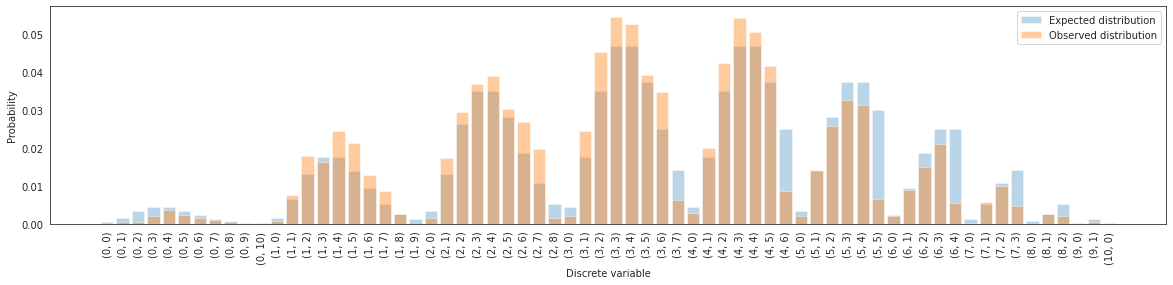

Rejection of the hypothesis, p-value: 5.003732143816233e-85


In [ ]:
chi2_test(distr_2, distr_MHalgo_2, N_iter, plot=True)

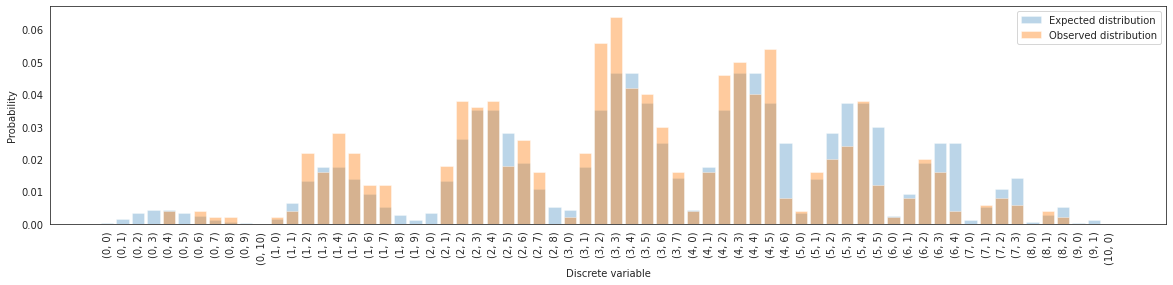

No rejection of the hypothesis, p-value: 0.042845177254891245


In [ ]:
# Subset every 10 iterations
subset_idx = np.arange(0, N_iter, 10)
trace_sub = []
for idx in subset_idx:
    trace_sub.append(trace[idx])

counts_dic = {(i, j): 0 for i in np.arange(m + 1) for j in np.arange(m + 1 - i)}
for s in trace_sub:
    counts_dic[s] += 1

tot = np.sum(list(counts_dic.values()))
distr_MHalgo_sub_2 = {k: v / tot for k, v in counts_dic.items()}

chi2_test(distr_2, distr_MHalgo_sub_2, tot)

### (b)
**Use Metropolis-Hastings, coordinate wise to generate variates from this distribution.**

In [ ]:
def sample_q_coordinate_wise(s, m, x_ax):

    neighbors = boundary_check(s, m)
    i, j = s

    ### if the neighbor list is empty we need to switch axis
    if (x_ax and ([coord for coord in neighbors if coord[0] == i] == [])) or (
        not x_ax and ([coord for coord in neighbors if coord[1] == j] == [])
    ):
        x_ax = not x_ax

    if x_ax:
        ## keep only elements in neighbors that are in x-axis
        neighbors = [coord for coord in neighbors if coord[0] == i]
    else:  ### keep only elements in neighbors that are in y-axis
        neighbors = [coord for coord in neighbors if coord[1] == j]

    if len(neighbors) <= 0:
        print("ax", x_ax)
        print("neighbors", neighbors)
        print("s", s)

    rand_idx = np.random.randint(0, len(neighbors))
    new_s = neighbors[rand_idx]
    return new_s, x_ax


def prob_q_coordinate_wise(given_s, m, x_ax):
    neighbors = boundary_check(given_s, m)
    i, j = given_s

    if x_ax:
        ### keep only elements in neighbors that are in x-axis
        neighbors = [coord for coord in neighbors if coord[0] == i]
    else:
        neighbors = [coord for coord in neighbors if coord[1] == j]

    prob = 1 / len(neighbors)
    return prob

In [ ]:
def MH_algorithm_2b(A1, A2, m, s_0, N_iter):
    trace = []
    s = s_0
    x_ax = True
    counter_accept = 0
    x_ax_counter = 0
    for n in range(N_iter):

        # Alternate between updating x-coordinate and y-coordinate dictated by x_ax
        i, j = s  # initial location
        s_star, x_ax = sample_q_coordinate_wise(s, m, x_ax)
        x_ax = (
            x_ax  ### axis might change after sampling (e.g. s = (10,0) and x_ax==True)
        )
        ratio = prob_q_coordinate_wise(s, m, x_ax) / prob_q_coordinate_wise(
            s_star, m, x_ax
        )  # q(s_star|s)/q(s|s_star)
        i_, j_ = s
        i, j = s_star
        ratio *= (
            A1 ** (i - i_)
            * A2 ** (j - j_)
            * np.math.factorial(i_)
            * np.math.factorial(j_)
        ) / (
            np.math.factorial(i) * np.math.factorial(j)
        )  # f/f

        alpha = min(1, ratio)
        if np.random.uniform() < alpha:  # Accept
            s = s_star
            counter_accept += 1

        trace.append(s)
        x_ax_counter += x_ax

        x_ax = not x_ax

    print(f"Proposal accepted {100 * counter_accept / N_iter:2.3f}% of the times")
    print("X ax counter", x_ax_counter)
    return trace

In [ ]:
N_iter = 50000
s_0 = (2, 2)
trace = MH_algorithm_2b(A1, A2, m, s_0, N_iter)

Proposal accepted 78.318% of the times
X ax counter 25000


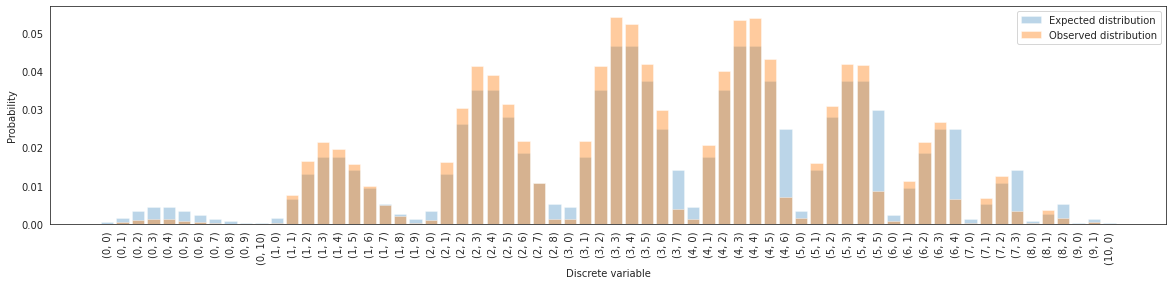

Rejection of the hypothesis, p-value: 0.0


In [ ]:
counts_dic = {(i, j): 0 for i in np.arange(m + 1) for j in np.arange(m + 1 - i)}
for s in trace:
    counts_dic[s] += 1

tot = np.sum(list(counts_dic.values()))
distr_MHalgo2b = {k: v / tot for k, v in counts_dic.items()}

chi2_test(distr_2, distr_MHalgo2b, tot, plot=True)

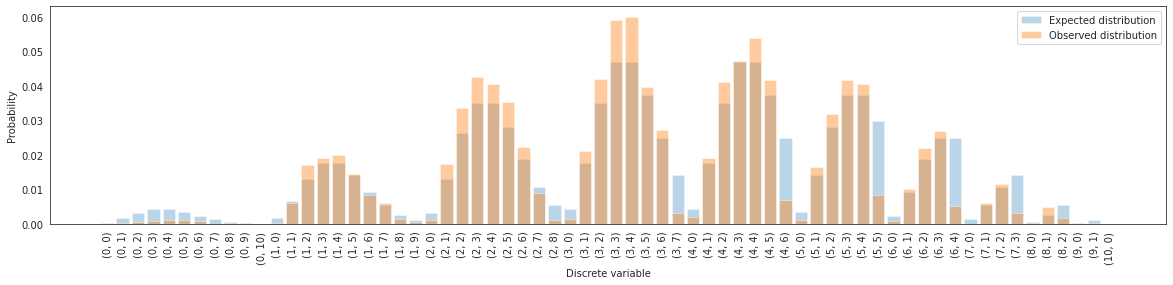

Rejection of the hypothesis, p-value: 3.043494547320154e-88


In [ ]:
# Subset every 10 iterations
subset_idx = np.arange(0, N_iter, 10)
trace_sub = []
for idx in subset_idx:
    trace_sub.append(trace[idx])

counts_dic = {(i, j): 0 for i in np.arange(m + 1) for j in np.arange(m + 1 - i)}
for s in trace_sub:
    counts_dic[s] += 1

tot = np.sum(list(counts_dic.values()))
distr_MHalgo_sub_2b = {k: v / tot for k, v in counts_dic.items()}

chi2_test(distr_2, distr_MHalgo_sub_2b, tot)

### (c)
**Use Gibbs sampling to sample from the distribution. This is (also) coordinate-wise but here we use the exact conditional distributions. You will need to find the conditional distributions analytically.**

$$
P(i|j) = \frac{P(i,j)}{P(j)} = \frac{P(i,j)}{\sum_{k=0}^{m-j}P(k,j)}
$$
$$
P(i|j) = \frac{c \cdot \frac{A_{1}^{i}}{i !} \frac{A_{2}^{j}}{j !} }{\sum_{k=0}^{m-j}c \cdot \frac{A_{1}^{k}}{k !} \frac{A_{2}^{j}}{j !}} = \frac{\frac{A_1^{i}}{i!}}{\sum_{k=0}^{m-j}\frac{A_1^{k}}{k!}}
$$

This is the truncated poisson distribution of Part 1 where $m$ is now $m-j$ and $A$ is $A_1$. (the denominator is simply the normalizing constant $c$)

Similarly,
$$
P(j|i) = \frac{\frac{A_{2}^{j}}{j!}}{\sum_{k=0}^{m-i}\frac{A_2^{k}}{k!}}
$$

This is the truncated poisson distribution of Part 1 where $m$ is now $m-i$ and $A$ is $A_2$.

In [ ]:
# P(x|y)


def conditional_probability(x, y, A, m):
    numerator = A**x / np.math.factorial(x)
    tmp = []
    for k in range(m - y):
        tmp += [A**k / np.math.factorial(k)]
    denominator = np.sum(tmp)

    return numerator / denominator

In [ ]:
def gibbs_sampler(A1, A2, m, s_0, N_iter):
    trace = []
    s = s_0
    x_ax = True
    counter_accept = 0
    x_ax_counter = 0
    for n in range(N_iter):

        # Alternate between updating x-coordinate and y-coordinate dictated by x_ax
        i, j = s  # initial location

        cond_prob = []
        state_space = []
        if x_ax:
            for x in range(m - j + 1):
                state_space += [(x, j)]
                cond_distr = truncated_Poisson_distr(A1, m - j)
                cond_prob = list(cond_distr.values())
                # cond_prob += [conditional_probability(x,j, A1, m-j)] # P(i|j)
        else:
            for y in range(m - i + 1):
                state_space += [(i, y)]
                # cond_prob += [conditional_probability(y, i, A2, m-i)] # P(j|i)
                cond_distr = truncated_Poisson_distr(A2, m - i)
                cond_prob = list(cond_distr.values())

        # Sampling
        idx = np.random.choice(np.arange(0, len(state_space)), p=cond_prob)
        s = state_space[idx]

        trace.append(s)

        x_ax_counter += x_ax
        x_ax = not x_ax

    print(f"Proposal accepted {100 * counter_accept / N_iter:2.3f}% of the times")
    print("X ax counter", x_ax_counter)
    return trace

In [ ]:
N_iter = 50000
s_0 = (2, 2)
trace = gibbs_sampler(A1, A2, m, s_0, N_iter)

Proposal accepted 0.000% of the times
X ax counter 25000


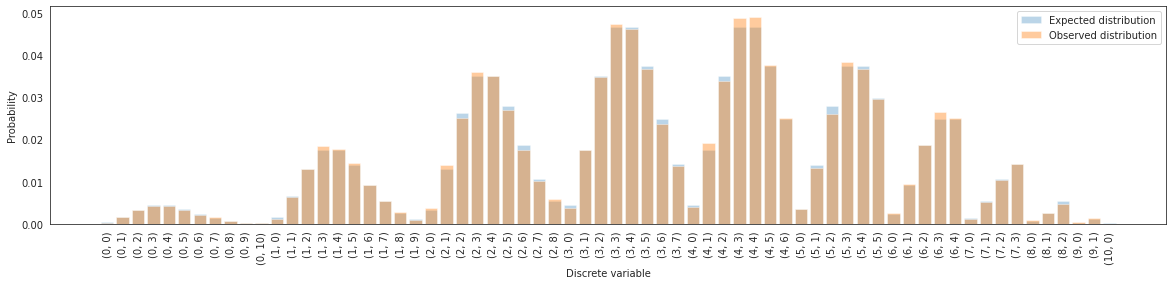

No rejection of the hypothesis, p-value: 0.00517449791319096


In [ ]:
counts_dic = {(i, j): 0 for i in np.arange(m + 1) for j in np.arange(m + 1 - i)}
for s in trace:
    counts_dic[s] += 1

tot = np.sum(list(counts_dic.values()))
distr_MHalgo2c = {k: v / tot for k, v in counts_dic.items()}

chi2_test(distr_2, distr_MHalgo2c, tot, plot=True)

## 3.
**We consider a Bayesian statistical problem. The observations are $X_{i} \sim \mathrm{N}(\Theta, \Psi)$, where the prior distribution of the pair $(\Xi, \Gamma)=(\log (\Theta), \log (\Psi))$ is standard normal with correlation $\rho=\frac{1}{2}$.**

**The joint density $f(x, y)$ of $(\Theta, \Psi)$ is**
$$
f(x, y)=\frac{1}{2 \pi x y \sqrt{1-\rho^{2}}} e^{-\frac{\log (x)^{2}-2 \rho \log (x) \log (y)+\log (y)^{2}}{2\left(1-\rho^{2}\right)}}
$$
**which can be derived using a standard change of variable technique. The task of this exercise is now to sample from the posterior distribution of $(\Theta, \Psi)$ using Markov Chain Monte Carlo.**


In [ ]:
def joint_density(x, y):
    rho = 1 / 2
    return np.exp(
        (-np.log(x) ** 2 - 2 * rho * np.log(x) * np.log(y) + np.log(y) ** 2)
        / (2 * (1 - rho**2))
    ) / (2 * np.pi * x * y * np.sqrt(1 - rho**2))

### (a)
**Generate a pair $(\theta, \psi)$ from the prior distribution, i.e. the distribution for the pair $(\Theta, \Psi)$, by first generating a sample $(\xi, \gamma)$ of $(\Xi, \Gamma)$**

In [ ]:
rho = 1 / 2
e, g = stats.multivariate_normal.rvs(mean=[0, 0], cov=[[1.0, rho], [rho, 1.0]])
theta_truth, psi_truth = np.exp(e), np.exp(g)
print(theta_truth, psi_truth)

0.5055233452593184 0.8265197750360043


### (b)
**Generate $X_{i}=1, \ldots, n$ with the values of $(\theta, \psi)$ you obtained in item 3a. Use $n=10$.**

In [ ]:
N = 10
X = np.random.normal(loc=theta_truth, scale=psi_truth, size=N)
print(X)

[ 0.42098518  1.45373793  0.54851793  1.6369206  -0.30969262  0.95074863
  0.19934479  1.73345797  1.12921703 -0.40509347]


### (c)
**Derive the posterior distribution of $(\Theta, \Psi)$ given the sample.**

$p(\Theta,\Psi|X) \propto p(X|\Theta, \Psi) p(\Theta, \Psi)$

**Hint 1** Apply Bayes theorem in the density version.

**Hint 2** The sample mean and sample variance are independent. The sample mean follows a normal distribution, while a scaled version of the sample variance follows a $\chi^{2}$ distribution.

In [ ]:
def posterior_probability(theta, psi, X):
    N = len(X)
    X_bar = np.mean(X)
    scaled_var = (N - 1) * np.var(X) / psi**2
    likelihood = stats.norm.pdf(X_bar, loc=theta, scale=psi) * stats.chi2.pdf(
        scaled_var, df=N - 1
    )
    # likelihood = stats.norm(X, loc=theta, scale=psi)
    prior = joint_density(theta, psi)
    post = likelihood * prior

    return post  # output proportional (not normalized)

### (d)
**Generate MCMC samples from the posterior distribution of $(\Theta, \Psi)$ using the Metropolis Hastings method.**

In [ ]:
def sample_proposal_parameters():
    rho = 1 / 2
    e, g = stats.multivariate_normal.rvs(mean=[0, 0], cov=[[1.0, rho], [rho, 1.0]])
    theta_star, psi_star = np.exp(e), np.exp(g)
    return theta_star, psi_star

In [ ]:
def MH_algorithm_3d(X, s_0, N_iter):
    counter_accept = 0
    trace = []

    s = s_0
    for n in range(N_iter):
        theta, psi = s

        theta_star, psi_star = sample_proposal_parameters()

        ratio = posterior_probability(theta_star, psi_star, X) / posterior_probability(
            theta, psi, X
        )
        alpha = min(1, ratio)
        if np.random.uniform() < alpha:  # Accept
            s = (theta_star, psi_star)
            counter_accept += 1

        # Else, reject and i stays i.
        trace.append(s)

    print(f"Proposal accepted {100 * counter_accept / N_iter:2.3f}% of the times")
    return trace

In [ ]:
N_iter = 10000
s_0 = (1, 1)
trace = MH_algorithm_3d(X, s_0, N_iter)

Proposal accepted 21.210% of the times


In [ ]:
def visualize_posterior(trace):
    thetas_empirical = [s[0] for s in trace]
    psis_empirical = [s[1] for s in trace]
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    hist = axes[0].hist(thetas_empirical, bins=50, density=True)
    axes[0].vlines(x=theta_truth, ymin=0, ymax=max(hist[0]), color="red")
    axes[0].set(title=r"$\theta$ value distribution")

    hist = axes[1].hist(psis_empirical, bins=50, density=True)
    axes[1].vlines(x=psi_truth, ymin=0, ymax=max(hist[0]), color="red")
    axes[1].set(title=r"$\psi$ value distribution")

    plt.show()

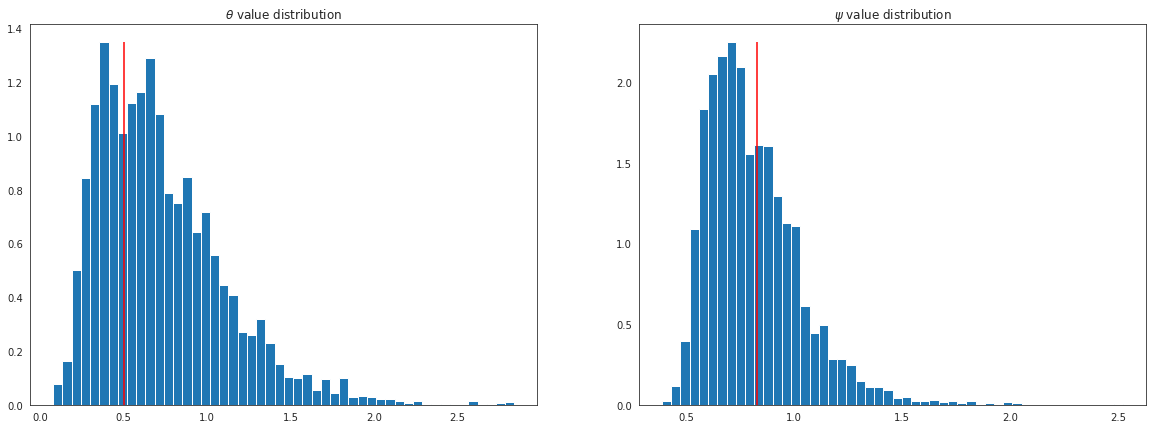

In [ ]:
visualize_posterior(trace)

### (e)
**Repeat item 3d with $n=100$ and $n=1000$, still using the values of $(\theta, \psi)$ from item 3a. Discuss the results.**

Proposal accepted 6.170% of the times


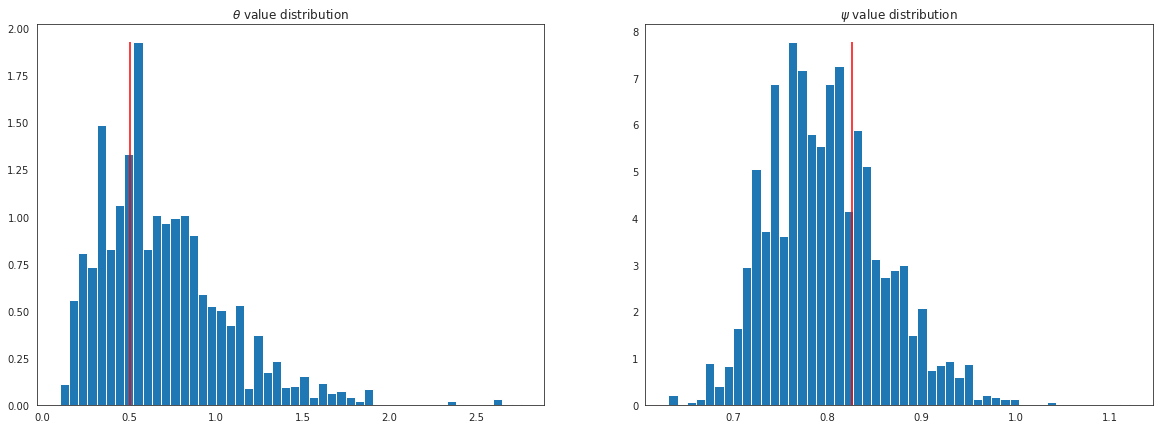

In [ ]:
N = 100
X_100 = np.random.normal(loc=theta_truth, scale=psi_truth, size=N)

N_iter = 10000
s_0 = (1, 1)
trace_100 = MH_algorithm_3d(X_100, s_0, N_iter)

visualize_posterior(trace_100)

Proposal accepted 1.960% of the times


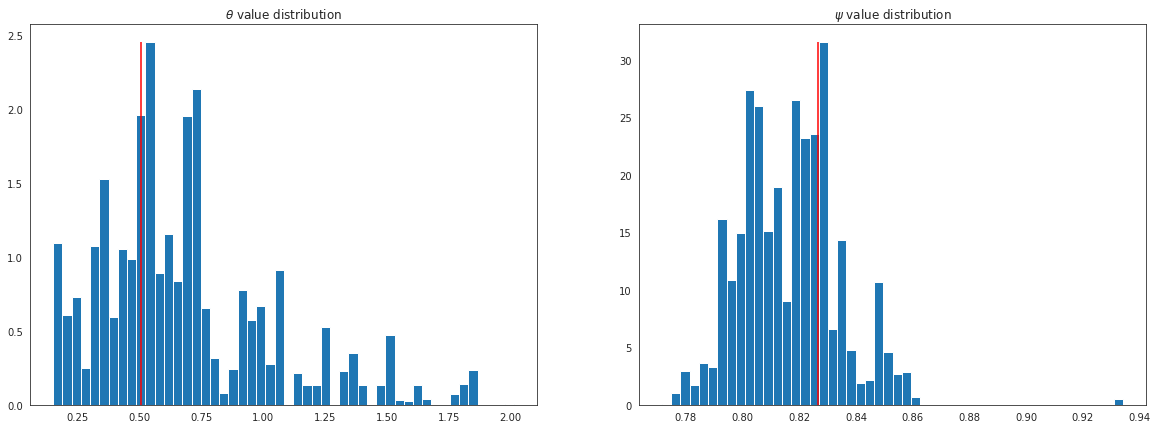

In [ ]:
N = 1000
X_1000 = np.random.normal(loc=theta_truth, scale=psi_truth, size=N)

N_iter = 10000
s_0 = (1, 1)
trace_1000 = MH_algorithm_3d(X_1000, s_0, N_iter)

visualize_posterior(trace_1000)

With more data points $X$, more observations, we expect the posterior probability to be more precise and to be closer to the true value of $\theta$ and $\psi$ used to generate $X$ (red lines).

Looking at the plots, we observed that this really depend on the run of the MCMC algorithm. Sometimes, the plot of the posterior probability were centered around the true values, sometimes they were way off.

We also see that the percentage of accepted proposal is quite low (1-3%), so that could mean that the MCMC algo is 'stuck' at some minimum state.